## Setup

In [2]:
!nvidia-smi

Tue Apr 15 23:50:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             18W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Install YOLO package

In [16]:
!pip install ultralytics

In [1]:
from ultralytics import YOLO 
import os
from IPython.display import display, Image 
from IPython import display 
display.clear_output()

In [2]:
import ultralytics
print(ultralytics.__version__)

8.3.108


## Evaluate Model's Performance

In [ ]:
from pathlib import Path
from crop_image import crop_resize_img_folder

#### Object Detection Model Inference

- Will select object detection model of choice
- Run inference on test dataset
- Output will be saved to /inference/run/detection

In [ ]:
ODmodel = YOLO("./ultralytics_runs/detect/train_yolov8s/weights/best.pt")
ODmodel = YOLO("./runs/detect/train_yolov8s/weights/best.pt")

test_folder_path = "../Dataset/YOLO_training/florida_five_anole_10000/test"
dest_folder_path = "../Dataset/YOLO_training/inference/run1/lizard_detection"


image 1/1 c:\Projects\OMSCS\Lizard_Classification\Anole_classifier\Spring_2025\..\Dataset\YOLO_training\original_train_val_test_split_labelled\knightanole_2000\test\images\36391_7586141_jpg.rf.e2455b787bd91590d15645f0fc79ad4d.jpg: 640x640 1 lizard, 145.7ms
Speed: 2.2ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to ..\Dataset\YOLO_training\inference\run1\lizarddetection\run9


In [ ]:
dict_anole = {0: "bark_anole",
              1: "brown_anole",
              2: "crested_anole",
              3: "green_anole",
              4: "knight_anole"}

In [ ]:

#Get images and text folder 
test_img_folder = Path(str(test_folder_path + "/images"))
test_txt_folder = Path(str(test_folder_path + "/labels"))

for key, value in dict_anole.items():
    dest_img_folder = Path(str(dest_folder_path + "/" + value + "/images"))
    dest_txt_folder = Path(str(dest_folder_path + "/" + value + "/labels"))

    # Create destination folder if it doesn't exist
    dest_img_folder.mkdir(parents=True, exist_ok=True)
    dest_txt_folder.mkdir(parents=True, exist_ok=True)

images = sorted(test_img_folder.glob('*'), key=lambda img_file: img_file.name)
images = [img_file for img_file in images if img_file.is_file()]

for image in images:

    img_name = image.stem

    # 1.Get ground truth label of image
    label_file_name = img_name + ".txt"
    label_file_path = str(test_txt_folder / label_file_name)

    with open(label_file_path, "r") as file:
        for line in file:
            data = line.strip().split() 

            class_ID, x_center, y_center, width, height = map(float, data)

    # Determine destination folder 

    class_label = dict_anole[class_ID]

    print(f"class label: {class_label}")

    dest_img_folder = Path(str(dest_folder_path + "/" + class_label + "/images"))
    dest_txt_folder = Path(str(dest_folder_path + "/" + class_label + "/labels"))

    #Get inference on image 
    img_file_name = img_name + ".jpg"
    img_file_path = str(test_img_folder / img_file_name)

    results = ODmodel(img_file_path)

    # 1.Save image with bounding box 
    dest_img_file_path = str(dest_img_folder / img_file_name)
    result = results[0]
    result.save(filename=dest_img_file_path)

    # 2.Get new bounding box coordinate
    xyxy = result.boxes.xyxy
    coord = tuple(xyxy[0].tolist())

    # 4.Write label text file using ground truth ID & coordinate

    dest_label_file_name = img_name + ".txt"
    dest_label_file_path = str(dest_txt_folder / dest_label_file_name)

    try:
        with open(dest_label_file_path, 'x') as file:  # 'x' mode creates only if file doesn't exist
            file.write(f"{class_ID} {coord[0]} {coord[1]} {coord[2]} {coord[3]}\n")
    except FileExistsError:
        print(f"Error: {dest_label_file_path} already exists!")

class label: knight_anole

image 1/1 c:\Projects\OMSCS\Lizard_Classification\Anole_classifier\Spring_2025\..\Dataset\YOLO_training\florida_five_anole_10000\test2\images\36391_7586141_jpg.rf.e2455b787bd91590d15645f0fc79ad4d.jpg: 640x640 1 lizard, 146.7ms
Speed: 2.8ms preprocess, 146.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Error: ..\Dataset\YOLO_training\inference\run1\lizard_detection\knight_anole\labels\36391_7586141_jpg.rf.e2455b787bd91590d15645f0fc79ad4d.txt already exists!


### Cropping Image
Will utilize cropping API to crop images in folder 

In [ ]:
src_folder_path = "../Dataset/YOLO_training/inference/run1/lizard_detection"
dest_folder_path = "../Dataset/YOLO_training/inference/run1/cropped_image"
resize = (384, 384)

for key, value in dict_anole.items():
    source_target = src_folder_path + "/" + value
    dest_target = str(dest_folder_path + "/" + value)

crop_resize_img_folder(source_target, dest_target, resize, coord_type="xyxy")

### Run inference from Classification model

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", "swin-base-patch4-window12-384-finetuned-lizard-class-swin-base")

In [ ]:
from datasets import load_dataset

cropped_dataset = load_dataset("../Dataset/YOLO_training/inference/run1/cropped_image")

In [ ]:
cropped_dataset.features

In [ ]:
image = cropped_dataset[0]
image["image"].resize((200, 200))

In [ ]:
target_image = image["image"]


In [ ]:
pipe(target_image)

### Classification on test dataset

In [ ]:
from evaluate import evaluator

task_evaluator = evaluator("image-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=cropped_dataset,
    metric= "accuracy",
    label_mapping=pipe.model.config.label2id
)

eval_results

### Evaluation with Confusion Matrix

In [ ]:
# Get class names mapping
label_names = cropped_dataset.features["label"].names

# Create a mapping from label names to indices
label_to_idx = {name: idx for idx, name in enumerate(label_names)}

# Prepare predictions and references
def predict_image(image):
    preds = pipe(image)
    name = preds[0]["label"]
    idx = label_to_idx[name]
    return idx  # Get the top prediction

# Get predicted labels
predictions_int = [predict_image(item["image"]) for item in cropped_dataset]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Get ground truth labels
references_int = [item["label"] for item in cropped_dataset]

In [ ]:
#Check predictions / ground truth labels
references_int

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
import evaluate 

# Compute confusion matrix
conf_matrix = evaluate.load("confusion_matrix")
results = conf_matrix.compute(predictions=predictions_int, references=references_int)

# Print confusion matrix results
print(results)

{'confusion_matrix': array([[185,   4,   6,   2,   3],
       [  3, 188,   8,   1,   0],
       [  7,  12, 179,   2,   0],
       [  0,   5,   0, 194,   1],
       [  1,   2,   0,   4, 193]])}


### Compute f1-score, precision and recall for each Anole class

In [ ]:
# Compute precision, recall, and F1-score
metric = evaluate.combine(["precision", "recall", 'f1'])
prf_results = metric.compute(predictions=predictions_int, references=references_int, average=None)  # No averaging, get per-class metrics

# Print per-class precision, recall, and F1-score
for i, class_name in enumerate(label_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {prf_results['precision'][i]:.4f}")
    print(f"  Recall: {prf_results['recall'][i]:.4f}")
    print(f"  F1-score: {prf_results['f1'][i]:.4f}")
    print("-" * 30)


Class: bark_anole
  Precision: 0.9439
  Recall: 0.9250
  F1-score: 0.9343
------------------------------
Class: brown_anole
  Precision: 0.8910
  Recall: 0.9400
  F1-score: 0.9148
------------------------------
Class: crested_anole
  Precision: 0.9275
  Recall: 0.8950
  F1-score: 0.9109
------------------------------
Class: green_anole
  Precision: 0.9557
  Recall: 0.9700
  F1-score: 0.9628
------------------------------
Class: knight_anole
  Precision: 0.9797
  Recall: 0.9650
  F1-score: 0.9723
------------------------------


### Visualize Confusion Matrix (Absolute Numbers)

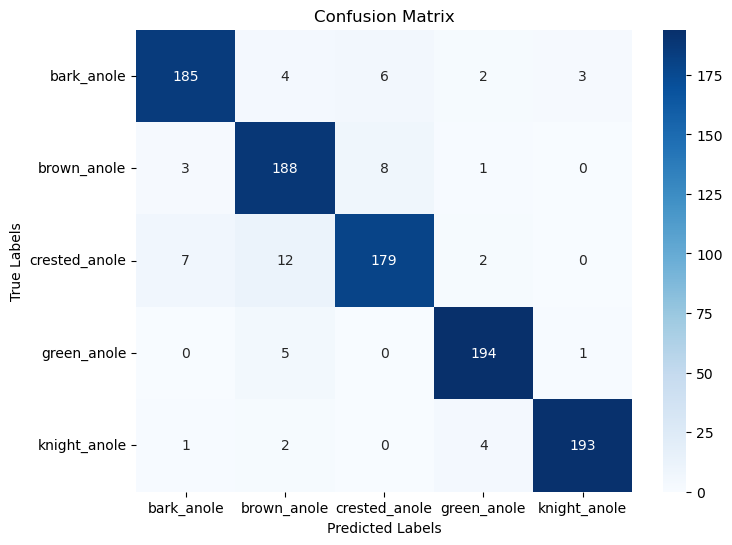

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array
conf_matrix = np.array(results["confusion_matrix"])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=cropped_dataset.features["label"].names, yticklabels=cropped_dataset.features["label"].names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Visualize Confusion Matrix (Normalized)

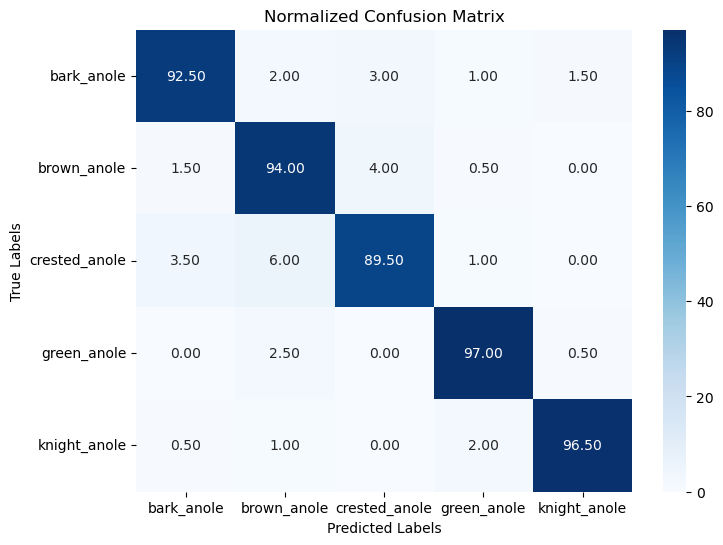

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array
conf_matrix = np.array(results["confusion_matrix"])

conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)

# Ensure NaNs (if any row sums to 0) are replaced with 0
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_normalized * 100,  # Convert to percentage
    annot=True, fmt=".2f", cmap="Blues",
    xticklabels=label_names, yticklabels=label_names
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()